### Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import power_transform, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error

### Reading the dataset from the system

In [2]:
dataset = pd.read_csv('Train_Flight.csv')
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR ? DEL,22:20,22-03-2021 01:10,2h 50m,non-stop,No info,3897
1,Air India,01-05-2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,10-06-2021 04:25,19h,2 stops,No info,13882
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
dataset.shape

(10683, 11)

### The data has 10683 columns and 11 rows to begin with

In [4]:
dataset['Route'].value_counts()

DEL ? BOM ? COK          2376
BLR ? DEL                1552
CCU ? BOM ? BLR           979
CCU ? BLR                 724
BOM ? HYD                 621
                         ... 
CCU ? VTZ ? BLR             1
CCU ? IXZ ? MAA ? BLR       1
BOM ? COK ? MAA ? HYD       1
BOM ? CCU ? HYD             1
BOM ? BBI ? HYD             1
Name: Route, Length: 128, dtype: int64

### Converting the Date of journey column into features like day, month, year and day name

In [5]:
dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'], errors = 'coerce')

In [6]:
dataset['year_of_jourey']  = dataset['Date_of_Journey'].dt.year
dataset['month_of_journey'] = dataset['Date_of_Journey'].dt.month
dataset['day_of_journey'] = dataset['Date_of_Journey'].dt.day

### The flight rates differ during week days and weekends, hence extracting the feature from the date of journey

In [7]:
dataset['day_of_week'] = dataset['Date_of_Journey'].dt.day_name()

In [8]:
dataset['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

### We can club the Jet Airways Business and Vistara Premium economy to the Jet Airways and Vistara respectively because they have very less occurances

In [9]:
dataset['Airline'] = np.where(dataset['Airline']=='Jet Airways Business','Jet Airways',
                             np.where(dataset['Airline']=='Vistara Premium economy','Vistara',dataset['Airline']))

In [10]:
dataset['Source'].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [11]:
dataset['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

### Basically New Delhi is same as Delhi, changing New Delhi to Delhi

In [12]:
dataset['Destination'] = np.where(dataset['Destination']=='New Delhi','Delhi',dataset['Destination'])

### Let's convert the Dep_time to Mornings, afternoon, evening and night, because the flight rate differs to the departure time as well

In [13]:
dataset['dep_min'] = pd.to_datetime(dataset['Dep_Time']).dt.minute
dataset['dep_hr'] = pd.to_datetime(dataset['Dep_Time']).dt.hour

In [14]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year_of_jourey,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr
0,IndiGo,2019-03-24,Banglore,Delhi,BLR ? DEL,22:20,22-03-2021 01:10,2h 50m,non-stop,No info,3897,2019,3,24,Sunday,20,22
1,Air India,2019-01-05,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,1,5,Saturday,50,5
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,10-06-2021 04:25,19h,2 stops,No info,13882,2019,9,6,Friday,25,9
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,12,5,Thursday,5,18
4,IndiGo,2019-01-03,Banglore,Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,1,3,Thursday,50,16


### Creating  features minute and Hours for the Arrival time like departure time

In [15]:
dataset['Arrival_Time'] = pd.to_datetime(dataset['Arrival_Time'], errors = 'coerce')
dataset['Arrival_min'] = dataset['Arrival_Time'].dt.minute
dataset['Arrival_hr'] = dataset['Arrival_Time'].dt.hour

### First splitting the data to hours and minutes and creating one feature only for total_minutes

In [16]:
dataset['dur_hrs'] = dataset['Duration'].str.split('h',expand = True)[0]
dataset['dur_mns'] = dataset['Duration'].str.split('h',expand = True)[1]


### I can see there are some spaces which is nothing but 0 hence imputing the same and removing the 'm's

In [17]:
dataset['dur_mns'].value_counts()

 30m    1446
        1031
 20m     997
 50m     972
 35m     939
 55m     910
 15m     903
 45m     896
 25m     803
 40m     637
 5m      623
 10m     525
Name: dur_mns, dtype: int64

### Adding the total minutes column by adding the hours and minutes

In [18]:
dataset['dur_mns'] = dataset['dur_mns'].str.replace('m','')

In [19]:
dataset['dur_mns'] = np.where(dataset['dur_mns']=='',0,dataset['dur_mns'])

In [20]:
dataset['dur_mns'] = dataset['dur_mns'].astype(float)

In [21]:
dataset['dur_hrs'] = dataset['dur_hrs'].replace('5m',0.05)

In [22]:
dataset['dur_hrs'] = dataset['dur_hrs'].astype(float)

In [23]:
dataset['Total_Mins'] = (dataset['dur_hrs']*60)+dataset['dur_mns']

In [24]:
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr,Arrival_min,Arrival_hr,dur_hrs,dur_mns,Total_Mins
0,IndiGo,2019-03-24,Banglore,Delhi,BLR ? DEL,22:20,2021-03-22 01:10:00,2h 50m,non-stop,No info,...,3,24,Sunday,20,22,10,1,2.0,50.0,170.0
1,Air India,2019-01-05,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,2021-08-11 13:15:00,7h 25m,2 stops,No info,...,1,5,Saturday,50,5,15,13,7.0,25.0,445.0
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,2021-10-06 04:25:00,19h,2 stops,No info,...,9,6,Friday,25,9,25,4,19.0,0.0,1140.0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,2021-08-11 23:30:00,5h 25m,1 stop,No info,...,12,5,Thursday,5,18,30,23,5.0,25.0,325.0
4,IndiGo,2019-01-03,Banglore,Delhi,BLR ? NAG ? DEL,16:50,2021-08-11 21:35:00,4h 45m,1 stop,No info,...,1,3,Thursday,50,16,35,21,4.0,45.0,285.0


### Removing the unnecessary columns as the features are extracted from them already

In [25]:
dataset = dataset.drop(columns = ['Date_of_Journey','Duration','dur_hrs','dur_mns','Arrival_Time','Route'])

In [26]:
dataset.head()

,Airline,Source,Destination,Dep_Time,Total_Stops,Additional_Info,Price,year_of_jourey,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr,Arrival_min,Arrival_hr,Total_Mins
0,IndiGo,Banglore,Delhi,22:20,non-stop,No info,3897,2019,3,24,Sunday,20,22,10,1,170.0
1,Air India,Kolkata,Banglore,05:50,2 stops,No info,7662,2019,1,5,Saturday,50,5,15,13,445.0
2,Jet Airways,Delhi,Cochin,09:25,2 stops,No info,13882,2019,9,6,Friday,25,9,25,4,1140.0
3,IndiGo,Kolkata,Banglore,18:05,1 stop,No info,6218,2019,12,5,Thursday,5,18,30,23,325.0
4,IndiGo,Banglore,Delhi,16:50,1 stop,No info,13302,2019,1,3,Thursday,50,16,35,21,285.0


### Checking for null values

In [27]:
dataset.isnull().sum()

Airline             0
Source              0
Destination         0
Dep_Time            0
Total_Stops         1
Additional_Info     0
Price               0
year_of_jourey      0
month_of_journey    0
day_of_journey      0
day_of_week         0
dep_min             0
dep_hr              0
Arrival_min         0
Arrival_hr          0
Total_Mins          1
dtype: int64

### deleting the rows with null values.

In [28]:
dataset = dataset.drop(columns = 'Dep_Time')

In [29]:
dataset1 = dataset.dropna(axis = 0)


### Null values have been treated

In [30]:
dataset1.isnull().sum()

Airline             0
Source              0
Destination         0
Total_Stops         0
Additional_Info     0
Price               0
year_of_jourey      0
month_of_journey    0
day_of_journey      0
day_of_week         0
dep_min             0
dep_hr              0
Arrival_min         0
Arrival_hr          0
Total_Mins          0
dtype: int64

### Checking for the datatypes for further uni-variate and bi-variate analysis

In [31]:
dataset1.dtypes

Airline              object
Source               object
Destination          object
Total_Stops          object
Additional_Info      object
Price                 int64
year_of_jourey        int64
month_of_journey      int64
day_of_journey        int64
day_of_week          object
dep_min               int64
dep_hr                int64
Arrival_min           int64
Arrival_hr            int64
Total_Mins          float64
dtype: object

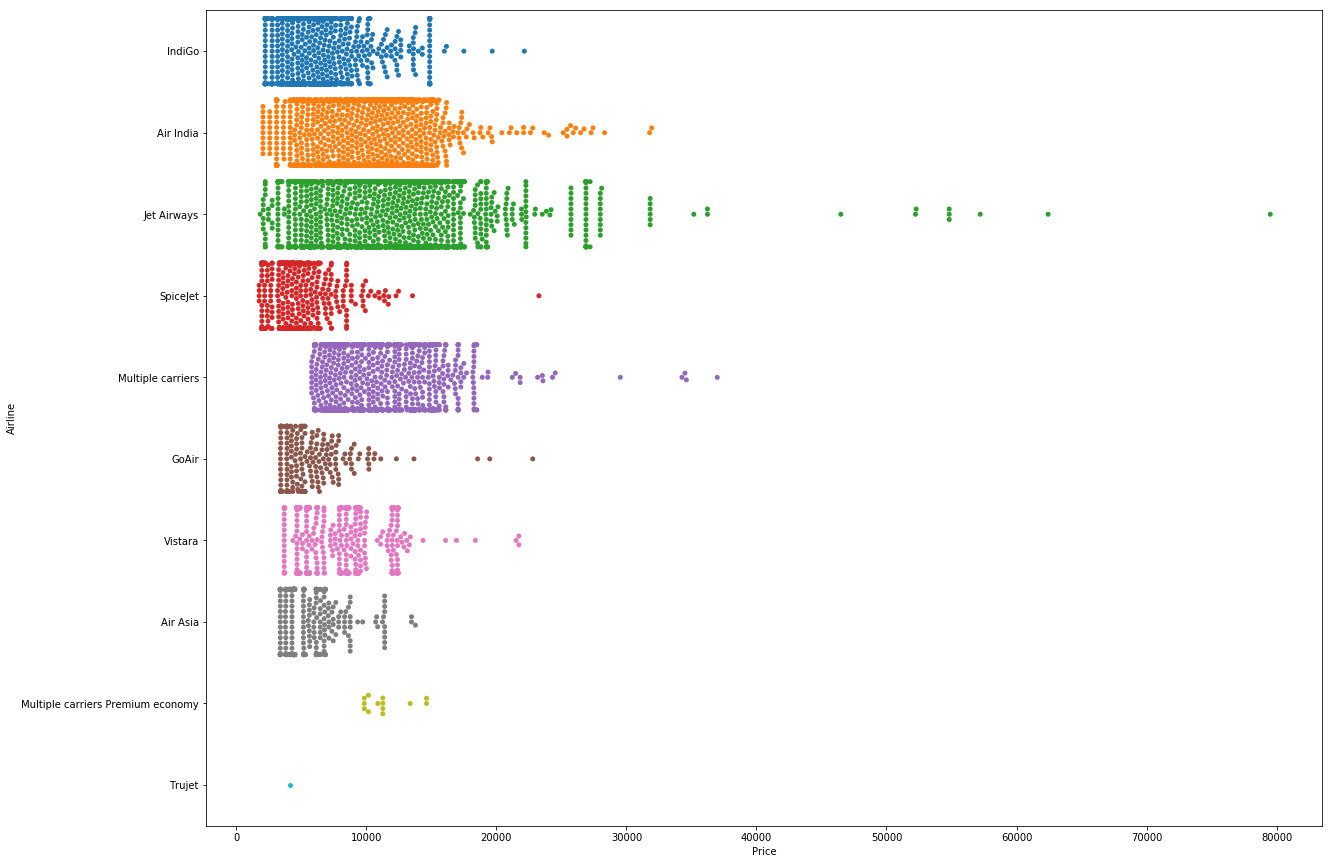

In [32]:
plt.figure(figsize = (20,15))
sns.swarmplot(y = 'Airline', x ='Price', data = dataset)

### From the above figure we can say that the price distribution differs as per the company, where most of the flight charges startes from approx 3000, However for multiple carriers the price starts from 7500

## Source and Price

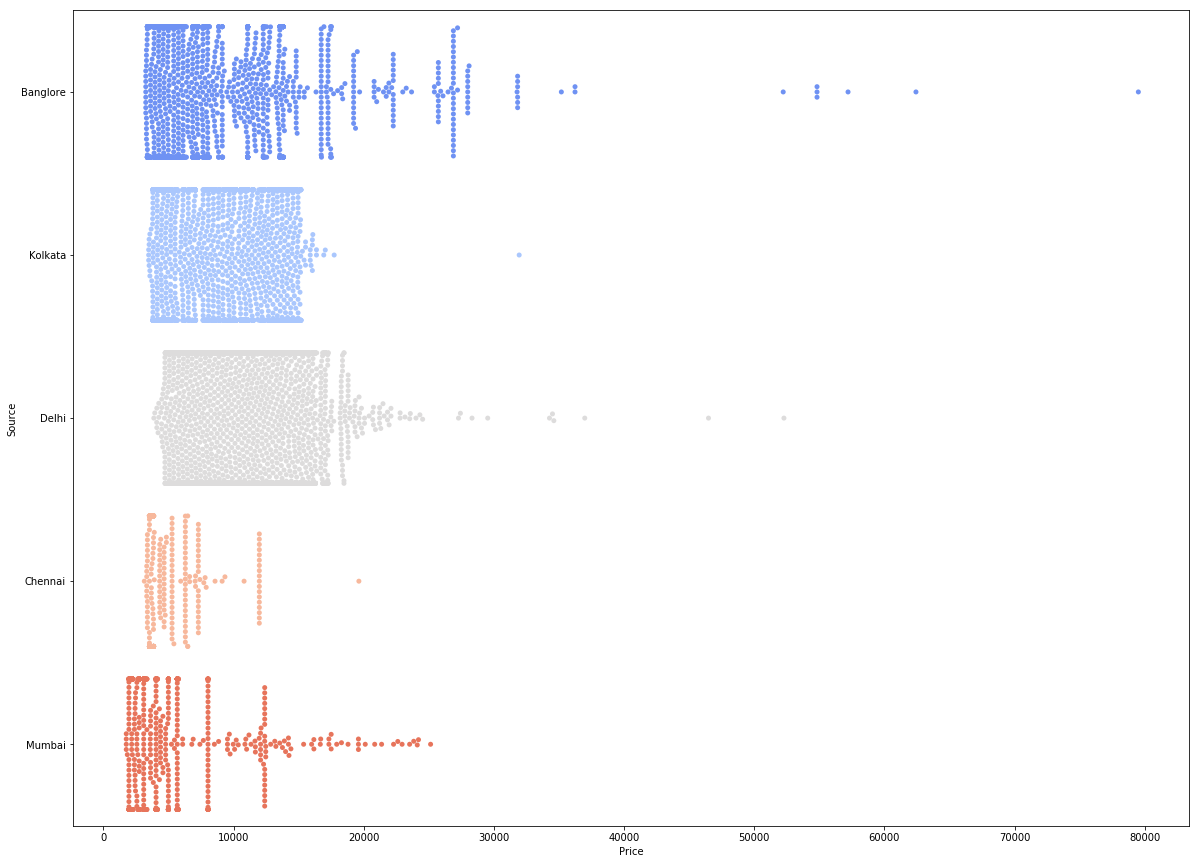

In [33]:
plt.figure(figsize = (20,15))
sns.swarmplot(y = 'Source', x ='Price', data = dataset, palette = 'coolwarm')

### From the above plot I can say that the flight prices range in Mumbai and Chennai is lesser than other source states and there is less number of people taking flights when compared to other cities

## Destination and Price

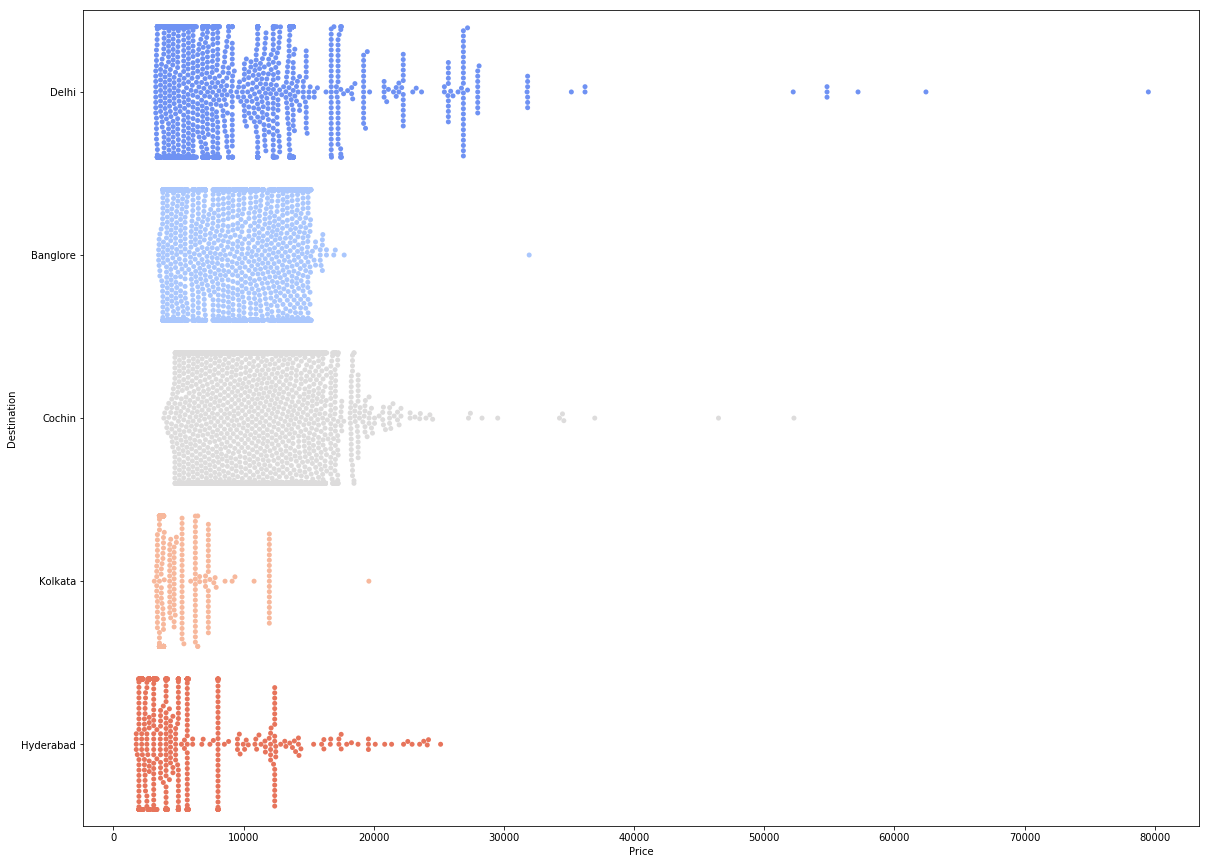

In [34]:
plt.figure(figsize = (20,15))
sns.swarmplot(y = 'Destination', x ='Price', data = dataset,palette = 'coolwarm')

### Upon reviewing the above graph I can conclude that the flights travelling to Hyderabad and Kolkata had lesser price when aompared to other states. and the people travelling were also less

## Departure time and Price

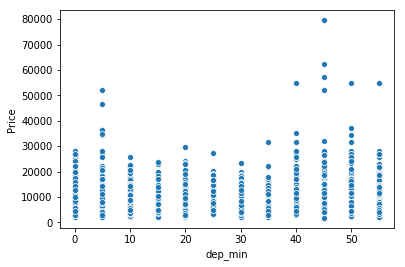

In [35]:
sns.scatterplot(y = 'Price', x ='dep_min', data = dataset,palette = 'coolwarm')

### from the above plot we can say that the flights during midnight and evening had lesser price when compared to remaining part of the day 

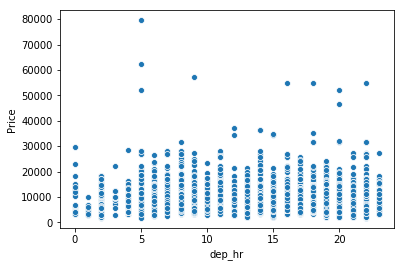

In [36]:
sns.scatterplot(y = 'Price', x ='dep_hr', data = dataset,palette = 'coolwarm')

## Price and Total Stops

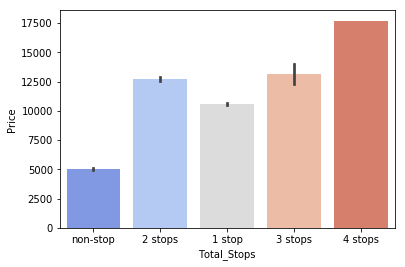

In [37]:
sns.barplot(y = 'Price', x ='Total_Stops', data = dataset,palette = 'coolwarm')

### From the above figure we can say that the number of stops is directly proportional to increase in flight price. Flights without any stops recorded the lowest price

## Additional info and price

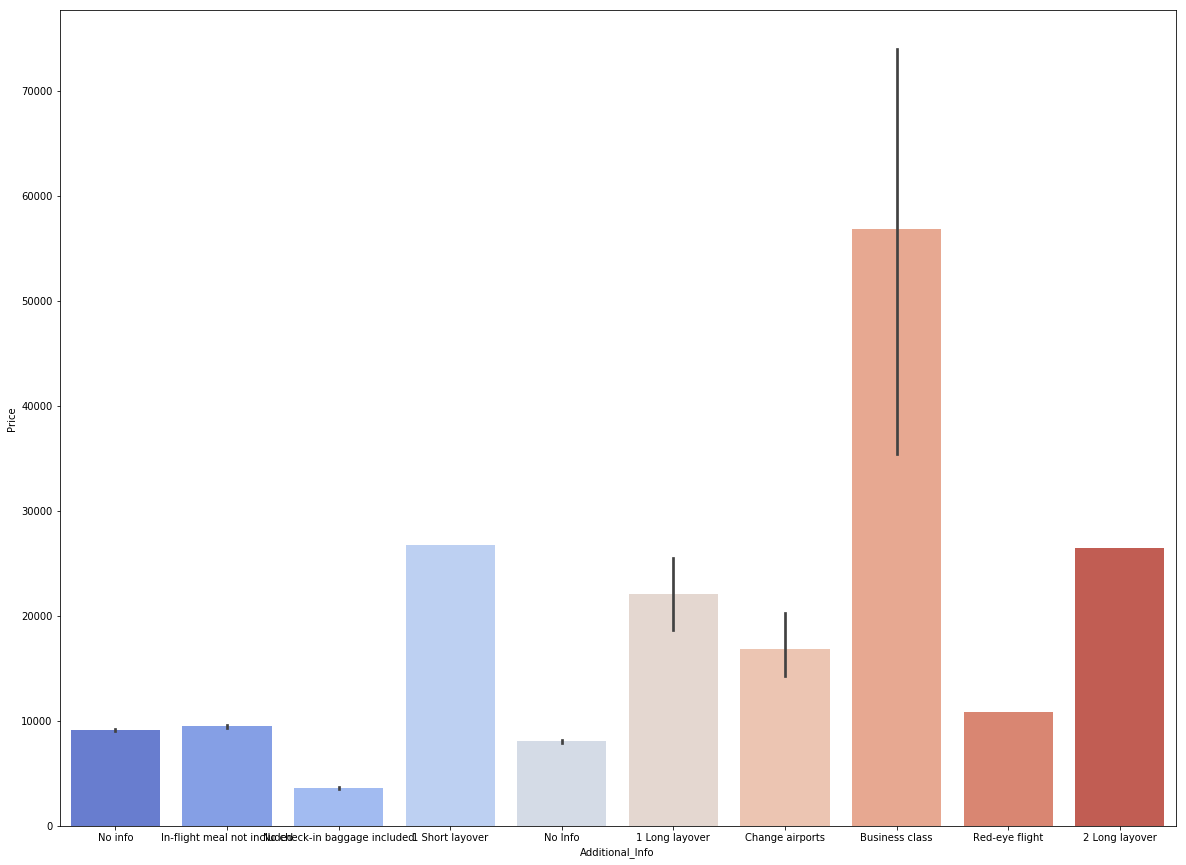

In [38]:
plt.figure(figsize = (20,15))
sns.barplot(y = 'Price', x ='Additional_Info', data = dataset,palette = 'coolwarm')

### From the above analysis, I can say that business class passengers had paid higher price when compared to others. The lowest was for the baggage included customers

## Year of journey and price

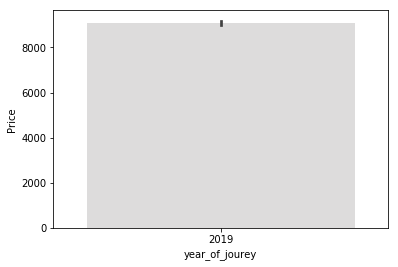

In [39]:
sns.barplot(y = 'Price', x ='year_of_jourey', data = dataset,palette = 'coolwarm')

### Since the column year_of_journey has only one value 2019, and it will not affect the price in any manner, hence removing the column

In [40]:
dataset1 = dataset1.drop(columns = 'year_of_jourey')

## Month of Journey V/s Price

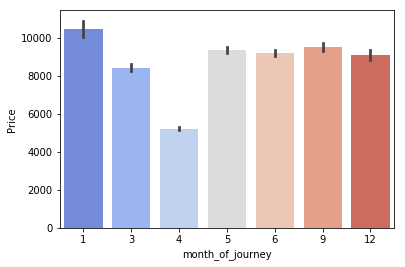

In [41]:
sns.barplot(y = 'Price', x ='month_of_journey', data = dataset,palette = 'coolwarm')

## Upon review, I can see that the prices were really high during January and lower during April, rest of the months were normal

## Day of Journey V/s Price

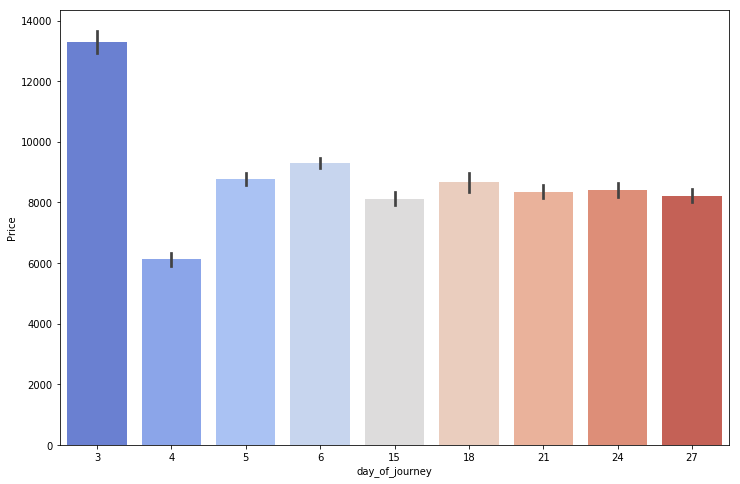

In [42]:
plt.figure(figsize = (12,8))
sns.barplot(y = 'Price', x ='day_of_journey', data = dataset,palette = 'coolwarm')

### Upon review, I can see that the prices were lower durig month ends , when compared to month start

## day of week v/s Price

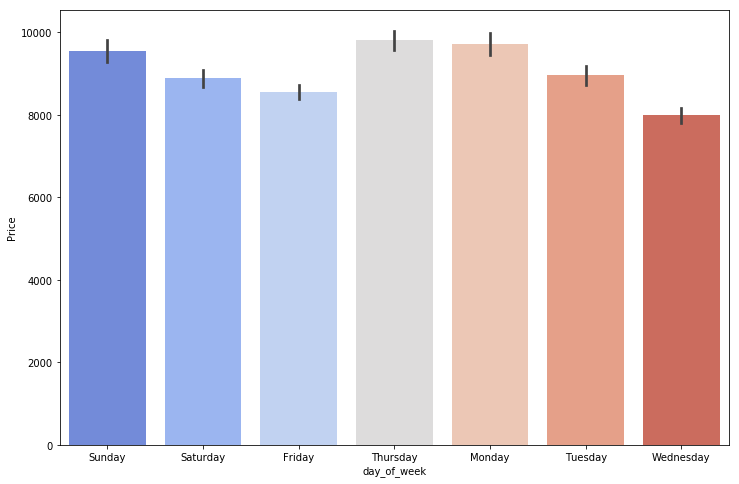

In [43]:
plt.figure(figsize = (12,8))
sns.barplot(y = 'Price', x ='day_of_week', data = dataset,palette = 'coolwarm')

### The lowest prices were recorded during wednesdays and Friday. The highest price were recorded on Thursdat and Monday

## Total duration of travel (Total Mins) and Price

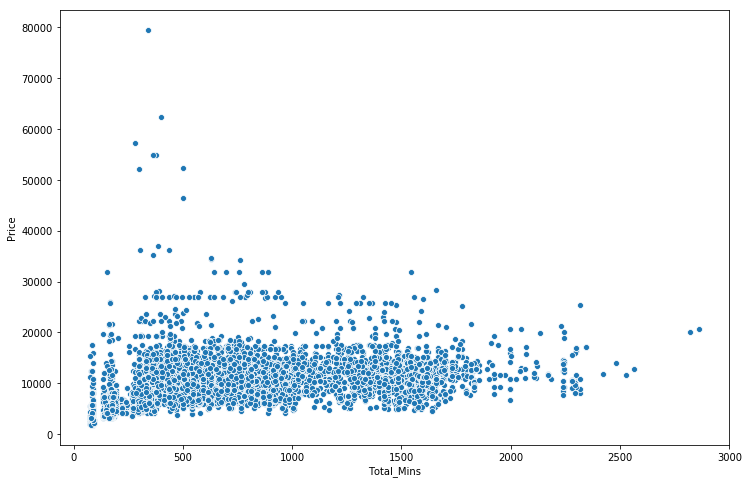

In [44]:
plt.figure(figsize = (12,8))
sns.scatterplot(y = 'Price', x ='Total_Mins', data = dataset,palette = 'coolwarm')

### There is no visible relation ship with the total mins and the price

### Let's encode the categorical variables

In [45]:
dataset1.dtypes

Airline              object
Source               object
Destination          object
Total_Stops          object
Additional_Info      object
Price                 int64
month_of_journey      int64
day_of_journey        int64
day_of_week          object
dep_min               int64
dep_hr                int64
Arrival_min           int64
Arrival_hr            int64
Total_Mins          float64
dtype: object

### Using the ordinal encoder to encode the categorical variables

In [46]:
enc = OrdinalEncoder()
for col in dataset1:
    if dataset1[col].dtypes == 'object':
        dataset1[col] = enc.fit_transform(dataset1[col].values.reshape(-1,1))

In [47]:
dataset1.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr,Arrival_min,Arrival_hr,Total_Mins
0,3.0,0.0,2.0,4.0,8.0,3897,3,24,3.0,20,22,10,1,170.0
1,1.0,3.0,0.0,1.0,8.0,7662,1,5,2.0,50,5,15,13,445.0
2,4.0,2.0,1.0,1.0,8.0,13882,9,6,0.0,25,9,25,4,1140.0
3,3.0,3.0,0.0,0.0,8.0,6218,12,5,4.0,5,18,30,23,325.0
4,3.0,0.0,2.0,0.0,8.0,13302,1,3,4.0,50,16,35,21,285.0


### Checking for correlation coefficient

In [48]:
corr = dataset1.corr()
corr['Price'].sort_values(ascending = False)

Price               1.000000
Total_Mins          0.506803
Arrival_hr          0.024183
Source              0.015713
month_of_journey    0.010681
dep_hr              0.006698
dep_min            -0.024692
Airline            -0.025631
day_of_week        -0.026419
Additional_Info    -0.065557
Arrival_min        -0.086489
day_of_journey     -0.165298
Destination        -0.262545
Total_Stops        -0.571266
Name: Price, dtype: float64

### We can see from the above coefficient, Total Mins has highest positive correlation of 0.5 and Total stops have highest negative correlation of -0.6

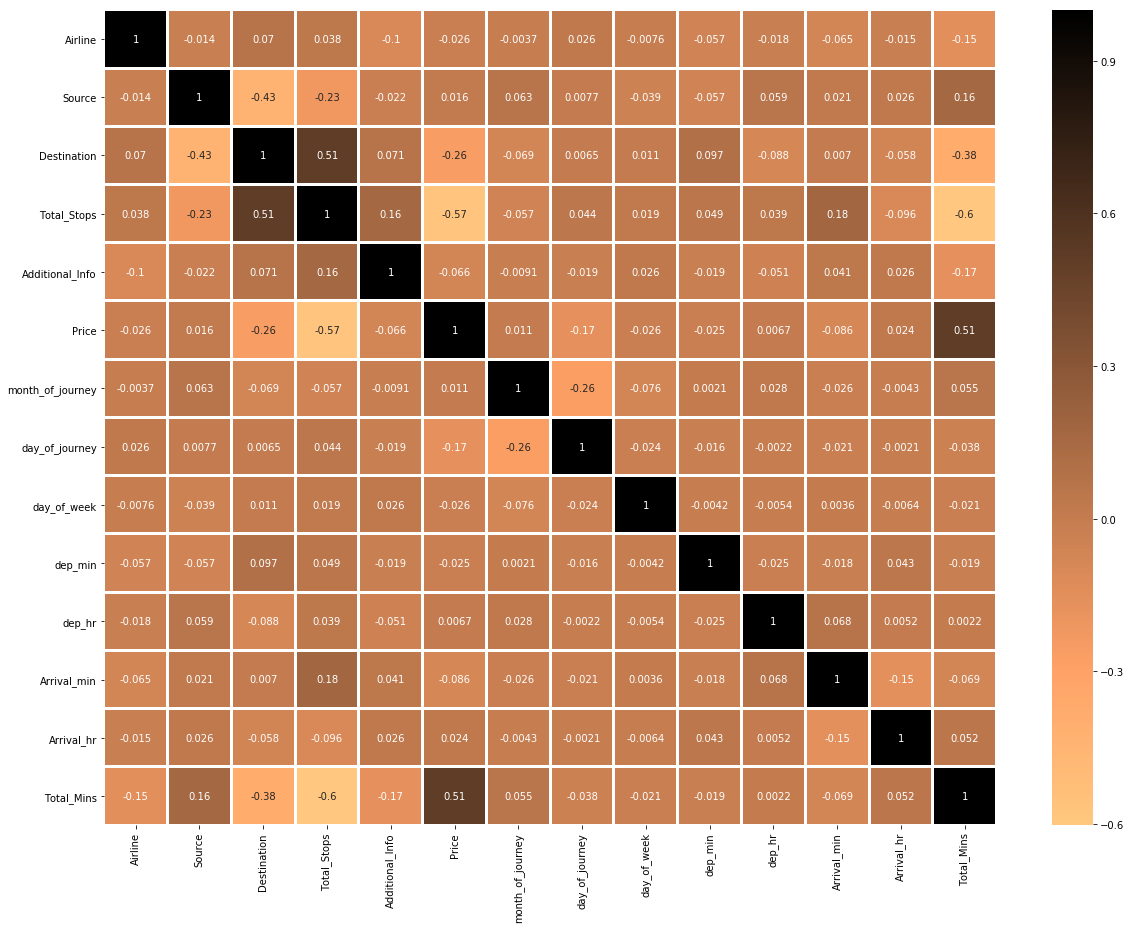

In [49]:
plt.figure(figsize = (20,15))
sns.heatmap(corr, annot = True, linewidths= 2, cmap = 'copper_r')

### There is no multi-collinearity issue with the dataset and the highest correlation coeffcient is -0.6 between total mins v/s total stops

## Checking for outliers in the continuous data columns for independent variables

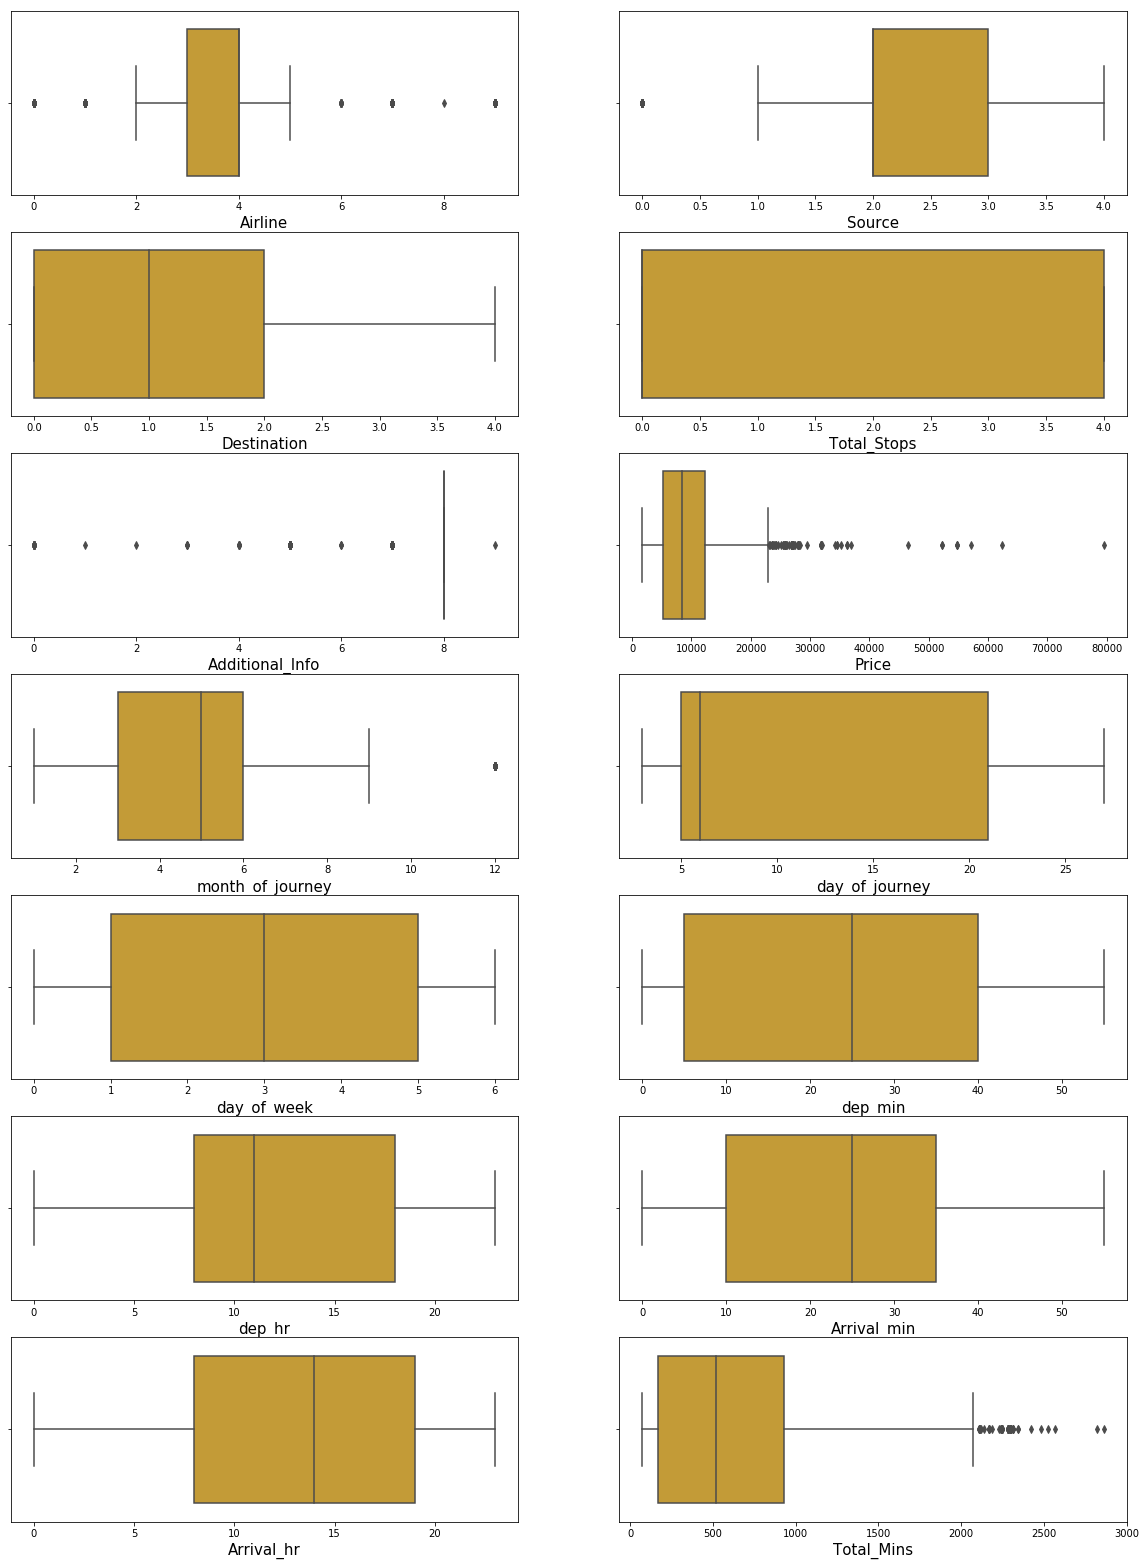

In [50]:
plt.figure(figsize = (20,40))
pltnum = 1

for i in dataset1:
    if pltnum <=19:
        plt.subplot(10,2,pltnum)
        sns.boxplot(dataset1[i],color = 'goldenrod')
        plt.xlabel(i, fontsize = 15)
    pltnum+=1
plt.show()

### There are few outliers for the Total Mins, let's remove them using score method

In [51]:
z = np.abs(zscore(dataset1[['Total_Mins']]))
z

,Total_Mins
0,0.931641
1,0.390081
2,0.978588
3,0.626398
4,0.705170
...,...
10678,0.971027
10679,0.961180
10680,0.911948
10681,0.951334


In [52]:
data_new = dataset1[(z<2.5).all(axis = 1)]
print(data_new.shape)
print(dataset1.shape)

(10576, 14)
(10681, 14)


### Data Loss is 1% there fore proeeding with the outlier removal

## Checking for data distribution

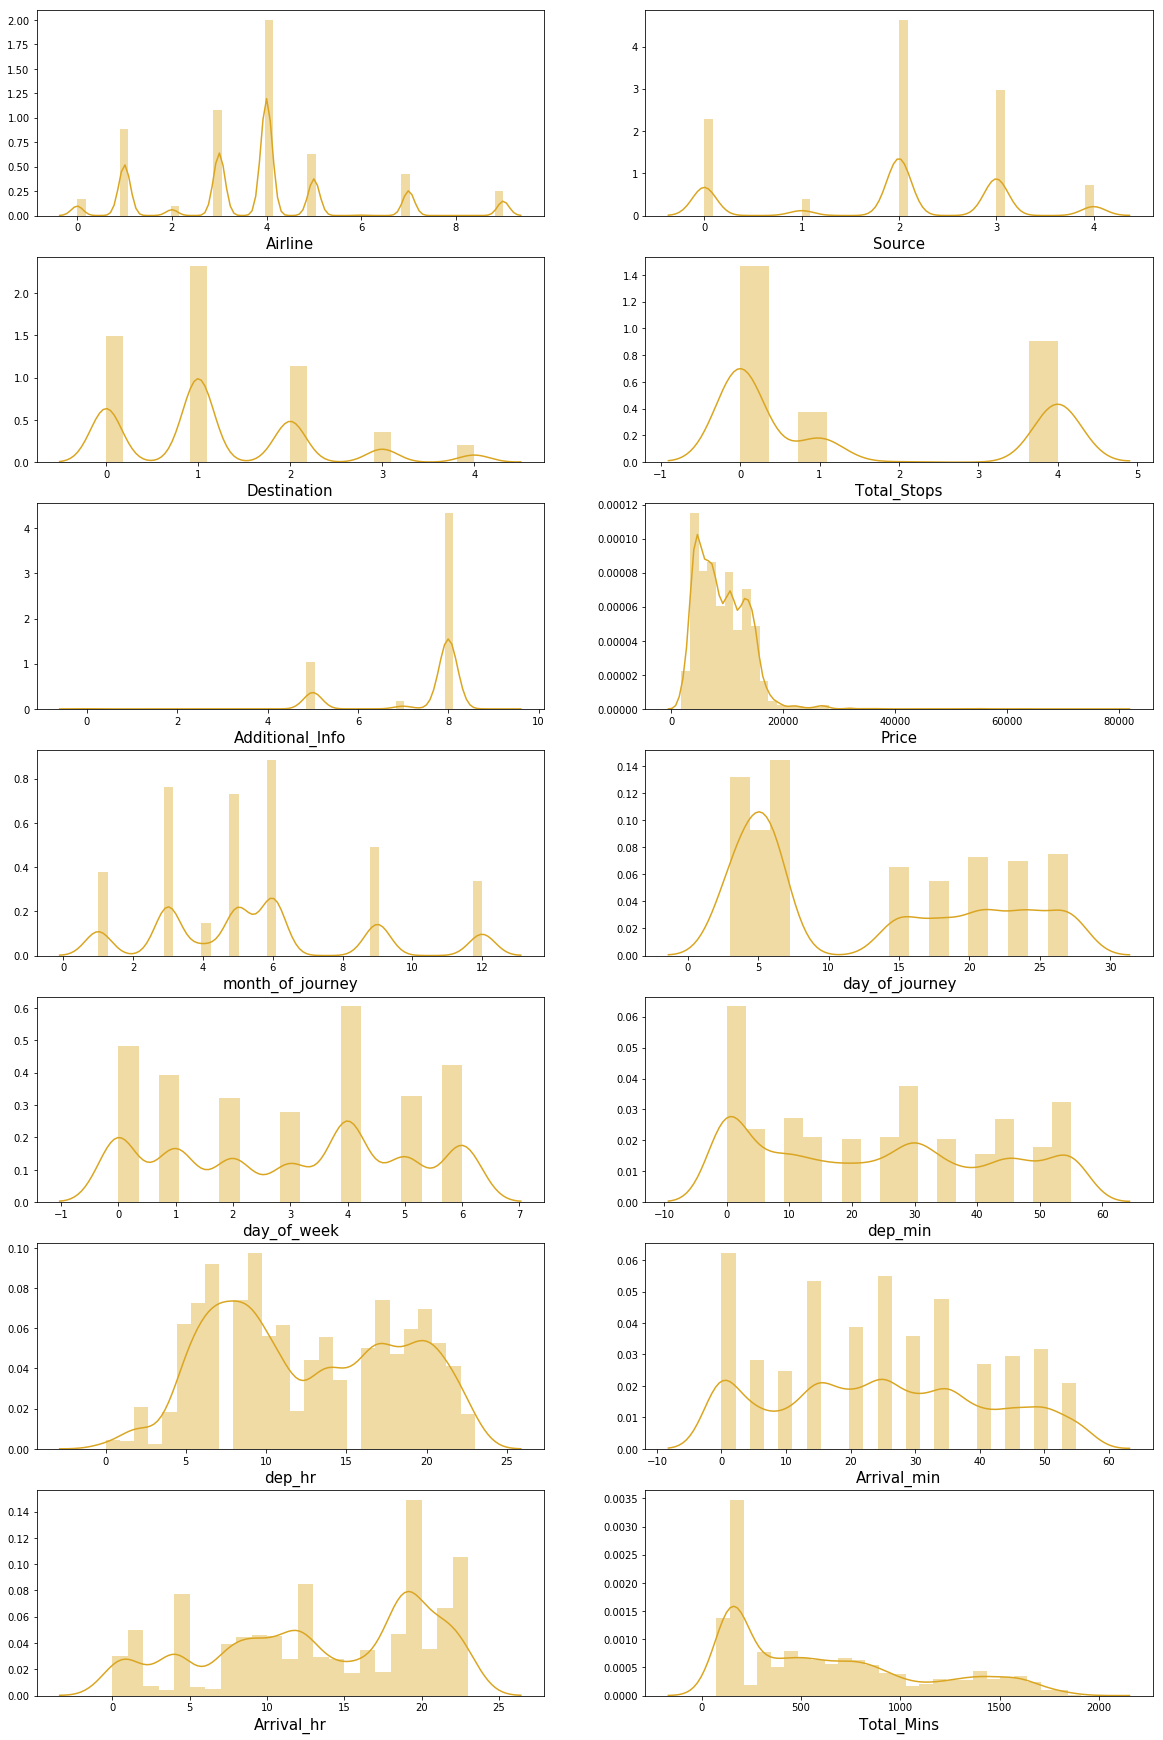

In [53]:
plt.figure(figsize = (20,90))
pltnum = 1

for i in data_new:
    if pltnum <=40:
        plt.subplot(20,2,pltnum)
        sns.distplot(data_new[i],color = 'goldenrod')
        plt.xlabel(i, fontsize = 15)
    pltnum+=1
plt.show()

### I can see the skewness on continuous data column let's check for skewness coefficient

In [54]:
data_new.skew()

Airline             0.542173
Source             -0.422377
Destination         0.842512
Total_Stops         0.624037
Additional_Info    -1.777799
Price               1.835408
month_of_journey    0.625283
day_of_journey      0.369243
day_of_week        -0.062887
dep_min             0.164677
dep_hr              0.104622
Arrival_min         0.107020
Arrival_hr         -0.362510
Total_Mins          0.754507
dtype: float64

### Upon reviewing, I can see that the total mins column has skewness above the limit (-0.5 to +0.5)

### Splitting the dataset to x and y

In [55]:
x = data_new.drop(columns = 'Price')
y = data_new['Price']

### Scaling the independent variables using Min Max Scaler

In [56]:
from sklearn.preprocessing import MinMaxScaler
scal = MinMaxScaler()
sc_data = scal.fit_transform(x)
x = pd.DataFrame(sc_data, columns = x.columns)

In [57]:
x.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr,Arrival_min,Arrival_hr,Total_Mins
0,0.333333,0.00,0.50,1.00,0.888889,0.181818,0.875000,0.500000,0.363636,0.956522,0.181818,0.043478,0.051771
1,0.111111,0.75,0.00,0.25,0.888889,0.000000,0.083333,0.333333,0.909091,0.217391,0.272727,0.565217,0.201635
2,0.444444,0.50,0.25,0.25,0.888889,0.727273,0.125000,0.000000,0.454545,0.391304,0.454545,0.173913,0.580381
3,0.333333,0.75,0.00,0.00,0.888889,1.000000,0.083333,0.666667,0.090909,0.782609,0.545455,1.000000,0.136240
4,0.333333,0.00,0.50,0.00,0.888889,0.000000,0.000000,0.666667,0.909091,0.695652,0.636364,0.913043,0.114441


### Using power transform to reduce the skewness on the dataset

In [58]:
tr_data = power_transform(x, method = 'yeo-johnson')
x = pd.DataFrame(tr_data, columns = x.columns)

### let's check for skewness again

In [59]:
x.skew()

Airline            -0.000203
Source             -0.111852
Destination         0.048779
Total_Stops         0.414481
Additional_Info    -1.338810
month_of_journey    0.012810
day_of_journey      0.139338
day_of_week        -0.092893
dep_min            -0.022527
dep_hr             -0.023130
Arrival_min        -0.038598
Arrival_hr         -0.163426
Total_Mins          0.160387
dtype: float64

## I can clearly see that the skewness is under control for the continuos columns

## Checking for outliers again

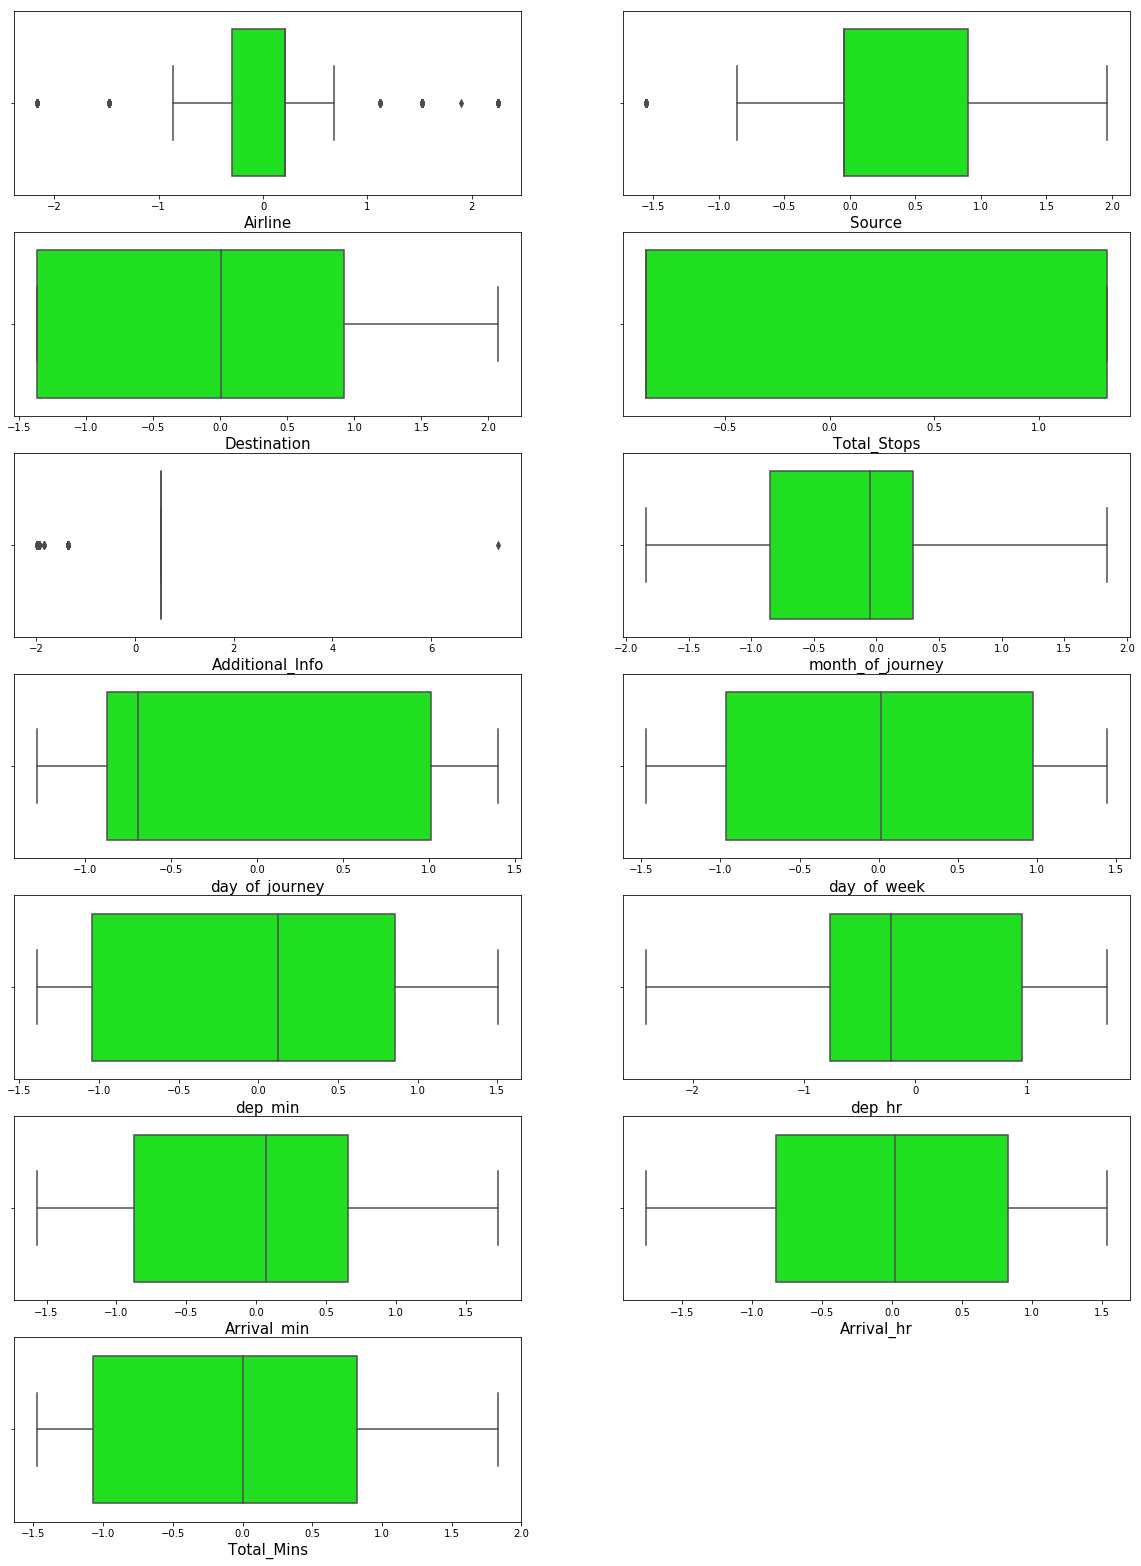

In [60]:
plt.figure(figsize = (20,40))
pltnum = 1

for i in x:
    if pltnum <=19:
        plt.subplot(10,2,pltnum)
        sns.boxplot(x[i],color = 'lime')
        plt.xlabel(i, fontsize = 15)
    pltnum+=1
plt.show()

### Outliers are removed for continuous data columns

### Proceeding with model building

### Finding the best random state to split the dataset

In [61]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
rs = 0
for i in range(0,2000):
    x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = i, test_size = 0.3)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    tr_score = lr.score(x_train,y_train)
    ts_score = lr.score(x_test,y_test)
    if round(tr_score*100,1) == round(ts_score*100,1):
        if i> rs:
            rs = i
print('the best random state is', rs)

the best random state is 1989


### Splitting the train test data using the best random state

In [62]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state =rs)

## Model 1: LinearRegression

In [63]:
lin = LinearRegression()
lin.fit(x_train,y_train)
lin_pred = lin.predict(x_test)
lin_score = lin.score(x_test,y_test)
lin_score

0.4134826255724623

In [64]:
lin_rmse = np.sqrt(mean_squared_error(y_test,lin_pred))
print('RMSE for Linear Regression: ', lin_rmse)

RMSE for Linear Regression:  3613.6013020018286


## Model 2: Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)
rfr_pred = rfr.predict(x_test)
rfr_score = rfr.score(x_test,y_test)
rfr_score

0.8728232114917964

In [66]:
rfr_rmse = np.sqrt(mean_squared_error(y_test,rfr_pred))
print('RMSE for Random Forest Regression: ', rfr_rmse)

RMSE for Random Forest Regression:  1682.6884746624764


## Model 3: Extra Trees Regressor

In [67]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor()
et.fit(x_train,y_train)
et_pred = et.predict(x_test)
et_score = et.score(x_test,y_test)
et_score

0.8868716549021735

In [68]:
et_rmse = np.sqrt(mean_squared_error(y_test,et_pred))
print('RMSE for Extra Trees Regression: ', et_rmse)

RMSE for Extra Trees Regression:  1587.0313659177762


## Model 4: XGB Regressor

In [69]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
xgb_pred = xgb.predict(x_test)
xgb_score = xgb.score(x_test,y_test)
xgb_score

0.8759664901525844

In [70]:
xgb_rmse = np.sqrt(mean_squared_error(y_test,xgb_pred))
print('RMSE for XGB Regression: ', xgb_rmse)

RMSE for XGB Regression:  1661.763860447637


## Model 5: KNN Regressor

In [71]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor()
kn.fit(x_train,y_train)
kn_pred = kn.predict(x_test)
kn_score = kn.score(x_test,y_test)
kn_score

0.7095258069098318

In [72]:
kn_rmse = np.sqrt(mean_squared_error(y_test,kn_pred))
print('RMSE for KNeighbors Regression: ', kn_rmse)

RMSE for KNeighbors Regression:  2543.042218020521


### Checking for over fitting model using cross val score

In [73]:
cv = cross_val_score(lin,x,y,scoring ='r2', cv = 5)
cv = cv.mean()
cv

0.4117333783734531

In [74]:
cv1 = cross_val_score(rfr,x,y,scoring ='r2', cv = 5)
cv1 = cv1.mean()
cv1

0.8618367810926312

In [75]:
cv2 = cross_val_score(et,x,y,scoring ='r2', cv = 5)
cv2 = cv2.mean()
cv2

0.8934018812533328

In [76]:
cv3 = cross_val_score(xgb,x,y,scoring ='r2', cv = 5)
cv3 = cv3.mean()
cv3

0.8765436094892387

In [77]:
cv4 = cross_val_score(kn,x,y,scoring ='r2', cv = 5)
cv4 = cv4.mean()
cv4

0.7165139629047808

## Selecting the best model

In [78]:
mod = [lin_score,rfr_score,et_score,xgb_score,kn_score]
cv = [cv,cv1,cv2,cv3,cv4]
rmse = [lin_rmse,rfr_rmse,et_rmse,xgb_rmse,kn_rmse]

model_sel = pd.DataFrame({})
model_sel['mod'] = mod
model_sel['cv'] = cv
model_sel['rmse'] = rmse
model_sel['diff'] = model_sel['mod'] - model_sel['cv']
model_sel


,mod,cv,rmse,diff
0,0.413483,0.411733,3613.601302,0.001749
1,0.872823,0.861837,1682.688475,0.010986
2,0.886872,0.893402,1587.031366,-0.006530
3,0.875966,0.876544,1661.763860,-0.000577
4,0.709526,0.716514,2543.042218,-0.006988


### Extra Trees Regressor is the best model

## Hyper parameter tuning

In [133]:
params = {'n_estimators':[100,150,200,250],
         'max_depth':[11,13,15,17],
         'min_samples_split':[3,4,6,8],
         'bootstrap':[True, False]
         }

In [134]:
gcv = GridSearchCV(ExtraTreesRegressor(),params,cv =5, n_jobs = -1)
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [11, 13, 15, 17],
                         'min_samples_split': [3, 4, 6, 8],
                         'n_estimators': [100, 150, 200, 250]})

In [135]:
gcv.best_params_

{'bootstrap': False,
 'max_depth': 17,
 'min_samples_split': 3,
 'n_estimators': 200}

In [136]:
fnl_mod = ExtraTreesRegressor(bootstrap = False, max_depth = 17, min_samples_split = 3, n_estimators = 200,n_jobs =-1)
fnl_mod.fit(x_train,y_train)
fnl_pred = fnl_mod.predict(x_test)
fnl_score = fnl_mod.score(x_test,y_test)
print(' The R2 score for the hyper tuned model is', fnl_score)

 The R2 score for the hyper tuned model is 0.8945630026537448


In [137]:
fnl_rmse = np.sqrt(mean_squared_error(y_test,fnl_pred))
print('RMSE for KNeighbors Regression: ', fnl_rmse)

RMSE for KNeighbors Regression:  1532.1324395405936


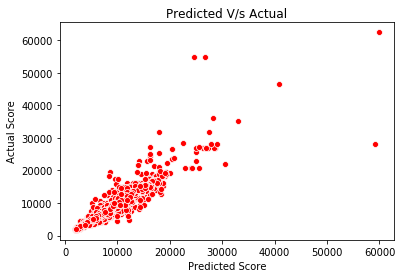

In [138]:
sns.scatterplot(x = fnl_pred, y = y_test, color = 'red')
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.title('Predicted V/s Actual')
plt.show()

### Using the same data cleaning process as train dataset and predicting the model on the test dataset

In [102]:
test_data = pd.read_csv(r'C:\Users\LENOVO\Documents\Post Graduation\data sets\Flight_Ticket_Participant_Datasets\Test_price.csv')
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


### Extracting features from the Date of Journey

In [103]:
test_data['Date_of_Journey'] = pd.to_datetime(test_data['Date_of_Journey'], errors = 'coerce')
test_data['year_of_jourey']  = test_data['Date_of_Journey'].dt.year
test_data['month_of_journey'] = test_data['Date_of_Journey'].dt.month
test_data['day_of_journey'] = test_data['Date_of_Journey'].dt.day

In [104]:
test_data['day_of_week'] = test_data['Date_of_Journey'].dt.day_name()

### Removing the duplicate data and merging it to the respective category

In [105]:
test_data['Airline'] = np.where(test_data['Airline']=='Jet Airways Business','Jet Airways',
                             np.where(test_data['Airline']=='Vistara Premium economy','Vistara',test_data['Airline']))

In [106]:
test_data['Destination'] = np.where(test_data['Destination']=='New Delhi','Delhi',test_data['Destination'])

### Extracting features from Dep Time

In [107]:
test_data['dep_min'] = pd.to_datetime(test_data['Dep_Time']).dt.minute
test_data['dep_hr'] = pd.to_datetime(test_data['Dep_Time']).dt.hour

In [108]:
test_data['Arrival_Time'] = pd.to_datetime(test_data['Arrival_Time'], errors = 'coerce')
test_data['Arrival_min'] = test_data['Arrival_Time'].dt.minute
test_data['Arrival_hr'] = test_data['Arrival_Time'].dt.hour

In [109]:
test_data['dur_hrs'] = test_data['Duration'].str.split('h',expand = True)[0]
test_data['dur_mns'] = test_data['Duration'].str.split('h',expand = True)[1]

In [110]:
test_data['dur_mns'] = test_data['dur_mns'].str.replace('m','')
test_data['dur_mns'] = np.where(test_data['dur_mns']=='',0,test_data['dur_mns'])
test_data['dur_mns'] = test_data['dur_mns'].astype(float)
test_data['dur_hrs'] = test_data['dur_hrs'].replace('5m',0.05)
test_data['dur_hrs'] = test_data['dur_hrs'].astype(float)
test_data['Total_Mins'] = (test_data['dur_hrs']*60)+test_data['dur_mns']

In [111]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,month_of_journey,day_of_journey,day_of_week,dep_min,dep_hr,Arrival_min,Arrival_hr,dur_hrs,dur_mns,Total_Mins
0,Jet Airways,2019-06-06,Delhi,Cochin,DEL ? BOM ? COK,17:30,2021-06-07 04:25:00,10h 55m,1 stop,No info,...,6,6,Thursday,30,17,25,4,10.0,55.0,655.0
1,IndiGo,2019-12-05,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,2021-08-11 10:20:00,4h,1 stop,No info,...,12,5,Thursday,20,6,20,10,4.0,0.0,240.0
2,Jet Airways,2019-05-21,Delhi,Cochin,DEL ? BOM ? COK,19:15,2021-05-22 19:00:00,23h 45m,1 stop,In-flight meal not included,...,5,21,Tuesday,15,19,0,19,23.0,45.0,1425.0
3,Multiple carriers,2019-05-21,Delhi,Cochin,DEL ? BOM ? COK,08:00,2021-08-11 21:00:00,13h,1 stop,No info,...,5,21,Tuesday,0,8,0,21,13.0,0.0,780.0
4,Air Asia,2019-06-24,Banglore,Delhi,BLR ? DEL,23:55,2021-06-25 02:45:00,2h 50m,non-stop,No info,...,6,24,Monday,55,23,45,2,2.0,50.0,170.0


In [112]:
test_data = test_data.drop(columns = ['Date_of_Journey','Duration','dur_hrs','dur_mns','Arrival_Time','Route','Dep_Time','year_of_jourey'])

## Encoding the data

In [114]:
test_data = test_data.dropna(axis = 0)

In [115]:
enc = OrdinalEncoder()
for col in test_data:
    if test_data[col].dtypes == 'object':
        test_data[col] = enc.fit_transform(test_data[col].values.reshape(-1,1))

## Removing outliers

In [118]:
zt = np.abs(zscore(test_data[['Total_Mins']]))
zt


,Total_Mins
0,0.029919
1,0.796714
2,1.563672
3,0.278905
4,0.936146
...,...
2666,1.583591
2667,0.966024
2668,0.487971
2669,0.547810


In [119]:
test_new = test_data[(zt<2.5).all(axis = 1)]
print(test_new.shape)
print(test_data.shape)

(2636, 13)
(2670, 13)


In [122]:
from sklearn.preprocessing import MinMaxScaler
scal = MinMaxScaler()
sc_data = scal.fit_transform(test_new)
test_new = pd.DataFrame(sc_data, columns = test_new.columns)

In [123]:
tr_data = power_transform(test_new, method = 'yeo-johnson')
test_new = pd.DataFrame(tr_data, columns = test_new.columns)

# Model prediction on the test data

In [124]:
test_pred = fnl_mod.predict(test_new)

In [128]:
test_pred =pd.DataFrame(test_pred)

In [129]:
test_pred.to_csv('test_pred.csv')

# Saving the final model

In [130]:
import joblib
joblib.dump(fnl_mod, 'Flight_price.pkl')

['Flight_price.pkl']